In [1]:
import qctoolkit as qtk
import numpy as np
from glob import glob
from copy import deepcopy
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# # API to import notebooks
# import io, os, sys, types
# from IPython import get_ipython
# from nbformat import read
# from IPython.core.interactiveshell import InteractiveShell

from qctoolkit.utilities.ipy_tools import *

/home/samio/local/miniconda2/lib/python2.7/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


missing file: mov2asc
please modify /path/to/qctoolkit/setting.py and recompile.


In [2]:
def FD_2nd(E, dx, center=None):
    """compute gradiant vector and hessian matrix
       e.g. E: shape (3, 3, 3, 3), dx: shape (4, )
       out: g: shape (4, ), hessian: shape(4, 4)
       expect E with 3 points for each dimension
    """
    
    def f2i(ind):
        """convert np array to int tuple for indexing"""
        return tuple(ind.astype(int).tolist())
    
    if center is None:
        i0 = np.ones(len(dx))
    else:
        i0 = np.asarray(center)
    g = np.zeros(len(dx))
    h = np.zeros([len(dx), len(dx)])
    for i in range(len(dx)):
        ind_p = i0.copy()
        ind_m = i0.copy()
        ind_p[i] += 1
        ind_m[i] -= 1 
        dE_xi = (E[f2i(ind_p)] - E[f2i(ind_m)]) / (2 * dx[i])
        g[i] = dE_xi
        
        for j in range(i, len(dx)):
            if i == j:
                dE_xixj = (E[f2i(ind_p)] - 2 * E[f2i(i0)] + E[f2i(ind_m)]) / (dx[i] ** 2)
            else:
                ind_pp = ind_p.copy()
                ind_pp[j] += 1
                ind_pm = ind_p.copy()
                ind_pm[j] -= 1
                ind_mp = ind_m.copy()
                ind_mp[j] += 1
                ind_mm = ind_m.copy()
                ind_mm[j] -= 1
                
                dE_xixj = (
                    (E[f2i(ind_pp)] - E[f2i(ind_pm)]) / (2 * dx[i]) - \
                    (E[f2i(ind_mp)] - E[f2i(ind_mm)]) / (2 * dx[i])
                ) / (2 * dx[j])
            
            h[i,j] = h[j,i] = dE_xixj
    return g, h

In [3]:
%%capture
import analysis_plots as nbplt

In [9]:
data_N2_3D = np.load('old/data_N2_3D_ZZR_pbe.npz')
E = data_N2_3D['E']
X = data_N2_3D['X']

In [13]:
# data_N2_pbe_charged = np.load('old/data_N2_production.npz')
# E = data_N2_pbe_charged['E']
# X = data_N2_pbe_charged['dZ'] + [7,7]

In [10]:
Z_A_full = sorted(set(X[:,0]))
Z_B_full = sorted(set(X[:,1]))
dR_full = sorted(set(X[:,2]))

In [11]:
X_meshes, E_mesh = nbplt.list2mesh(data_N2_3D)
_, E_grid = FD_2nd(E_mesh, [1,1,0.1666666], center=[3,3,3])
np.linalg.eigh(E_grid)

(array([-41.55438704,  -3.09741849,  -3.03920651]),
 array([[ 1.02101159e-01,  7.07106187e-01,  6.99697216e-01],
        [ 1.02101159e-01, -7.07107376e-01,  6.99696014e-01],
        [-9.89520443e-01, -1.22909391e-07,  1.44392844e-01]]))

<IPython.core.display.Javascript object>


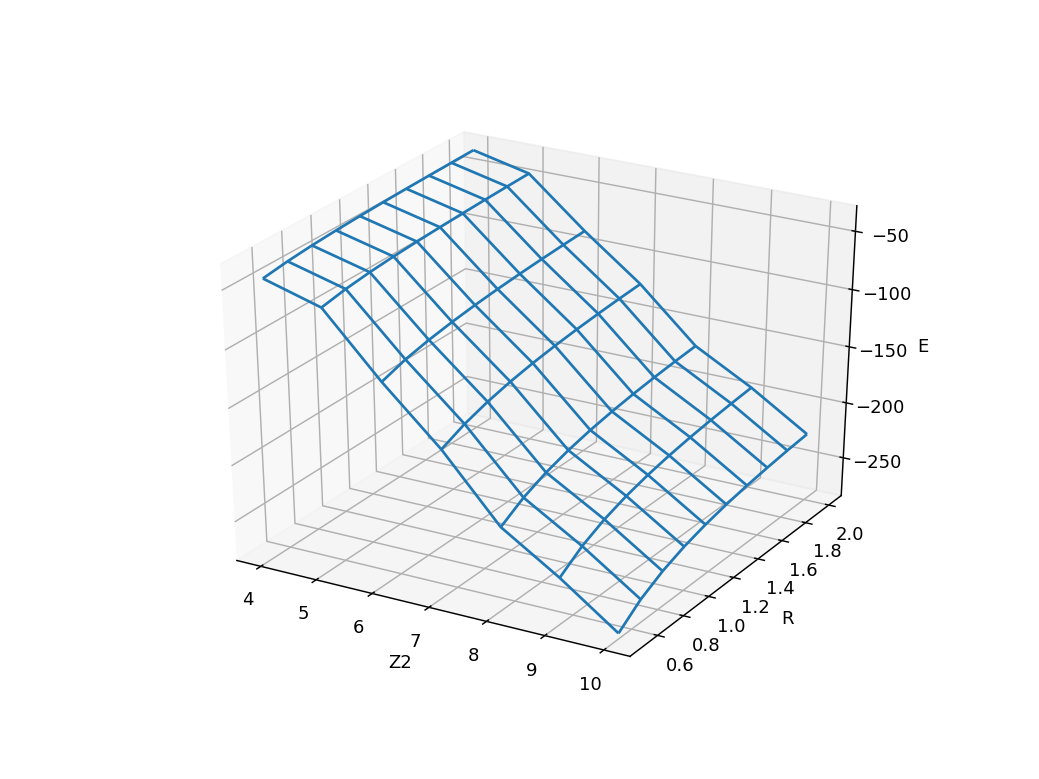

In [12]:
nbplt.E_2D(data_N2_3D, axes=[1,2])

In [14]:
dX_N2 = X - [7,7,1.1]

In [15]:
dX_CO = X - [6,8,1.1]

<IPython.core.display.Javascript object>


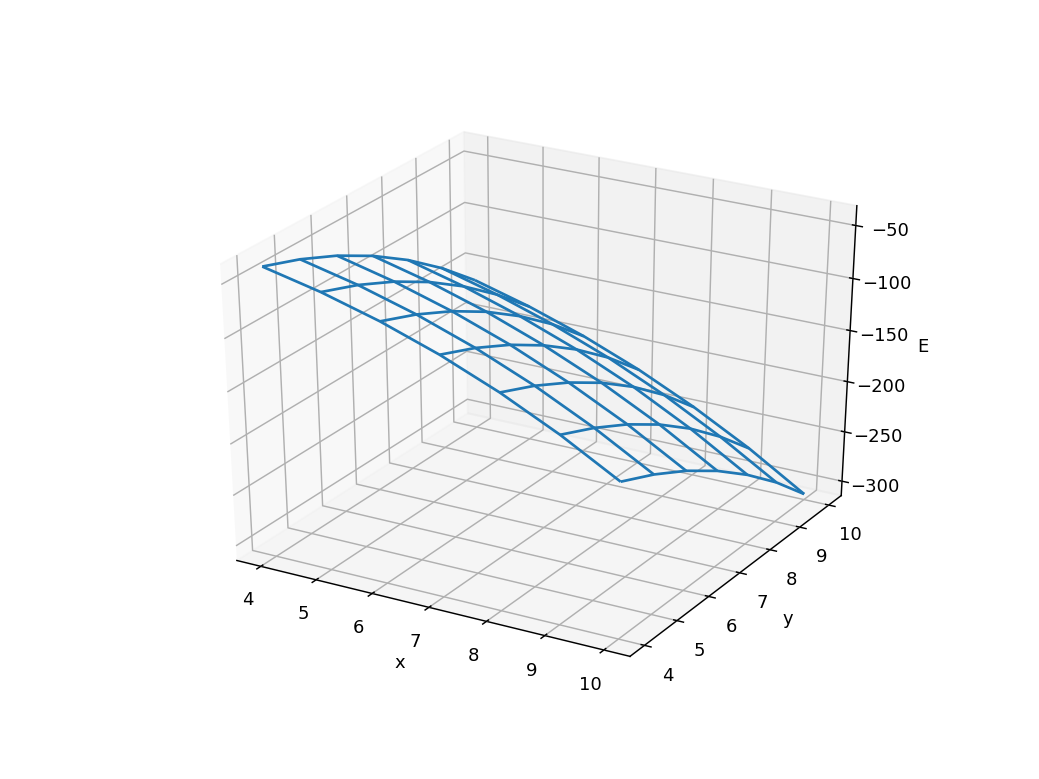

In [16]:
Xs, Es = nbplt.list2mesh(data_N2_3D)
test_data = {'x_mesh': Xs[0][:,:,3], 'y_mesh': Xs[1][:,:,3], 'E_mesh': Es[:,:,3]}
nbplt.E_2D(test_data)

In [17]:
def dX_2nd(dX_list):
    """construct quadratic form from 
       dX_list=[[dx1,dy1,dz1],
                [dx2,dy2,dz2],
                ...
                ]
       return dx1^2, 2dxdy, 2dxdz, dy^2, 2dydz, dz^2
       
       used for quadratic fit
    """
    out = []
    for i in range(dX_list.shape[1]):
        for j in range(i, dX_list.shape[1]):
            if i == j:
                out.append([dX_list[:,i] * dX_list[:,j]])
            else:
                out.append([2 * dX_list[:,i] * dX_list[:,j]])
    return np.vstack(out).T

In [127]:
def dE_prd_hessian(dX_list, g, H):
    """from gradiant and hessian construct quadric approximation based on dX"""
    g, H = np.asarray(g), np.asarray(H)
    if len(g) == 3:
#         E = np.zeros(dX_list.shape[0])
#         for i in range(dX_list.shape[1]):
#             for j in range(i, dX_list.shape[1]):
#                 if i == j:
#                     E += g[i] * dX_list[:,i] + 0.5 * H[i,i] * dX_list[:,i] ** 2
#                 else:
#                     E += H[i,j] * dX_list[:,i] * dX_list[:,j]
        E1 = g.dot(dX_list.T)
        E2 = np.einsum('ij,ij->i', dX_list.dot(H), dX_list)
        E = E1 + 0.5 * E2
    else:
        dN = dX_list[:,:2].sum(1)
        dX4 = np.hstack([dX_list, dN[:,np.newaxis]])
        w, v = np.linalg.eigh(H)
        dX4_eig = dX4.dot(v)
        E1 = g.dot(dX4.T)
        #E2 = np.einsum('ij,ij->', dX4_eig.dot(H), dX4_eig)
        E2 = np.einsum('ij,ij->i', dX4_eig * w, dX4_eig)
        E = E1 + 0.5 * E2
    return E

In [128]:
data_pbe = np.load('gaussian_N2_pbe.npz')
data_pbe.keys()
En = data_pbe['E_neutral']
Xn = data_pbe['X_neutral']
dx = data_pbe['dx']
gn2, hn2 = data_pbe['g_N2'], data_pbe['h_N2']
gco, hco = data_pbe['g_CO'], data_pbe['h_CO']
gbf, hbf = data_pbe['g_BF'], data_pbe['h_BF']

In [129]:
E_prd = dE_prd_hessian(dX_N2, gn2[:3], hn2[:3, :3]) + Es[3,3,3]
data_prd = {'E': E_prd, 'X': X}
Xs, Es_prd_mesh = nbplt.list2mesh(data_prd)

In [130]:
E_prd_dN = dE_prd_hessian(dX_N2, gn2, hn2) + Es[3,3,3]
data_prd_dN = {'E': E_prd_dN, 'X': X}
Xs, Es_prd_mesh_dN = nbplt.list2mesh(data_prd_dN)

In [131]:
E_prd - E_prd_dN

array([ 3.15283146,  3.09382965,  3.03482784,  2.97582603,  2.91682422,
        2.85782241,  2.7988206 ,  2.73981879,  2.68081698,  2.62181517,
        3.15283146,  3.09382965,  3.03482784,  2.97582603,  2.91682422,
        2.85782241,  2.7988206 ,  2.73981879,  2.68081698,  2.62181517,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        1.31092685,  1.27159231,  1.23225777,  1.19292323,  1.15358869,
        1.11425415,  1.07491961,  1.03558507,  0.99625053,  0.95691599,
        1.31092685,  1.27159231,  1.23225777,  1.19292323,  1.15358869,
        1.11425415,  1.07491961,  1.03558507,  0.99625053,  0.95691599,
        0.53097776,  0.55064503,  0.5703123 ,  0.58997957,  0.60964684,
        0.62931411,  0.64898138,  0.66864865,  0.68831592,  0.70

In [132]:
E_prd_CO = dE_prd_hessian(dX_CO, gco[:3], hco[:3,:3]) + Es[2,4,3]
data_prd_CO = {'E': E_prd_CO, 'X': X}
_, Es_prd_CO_mesh = nbplt.list2mesh(data_prd_CO)

<IPython.core.display.Javascript object>


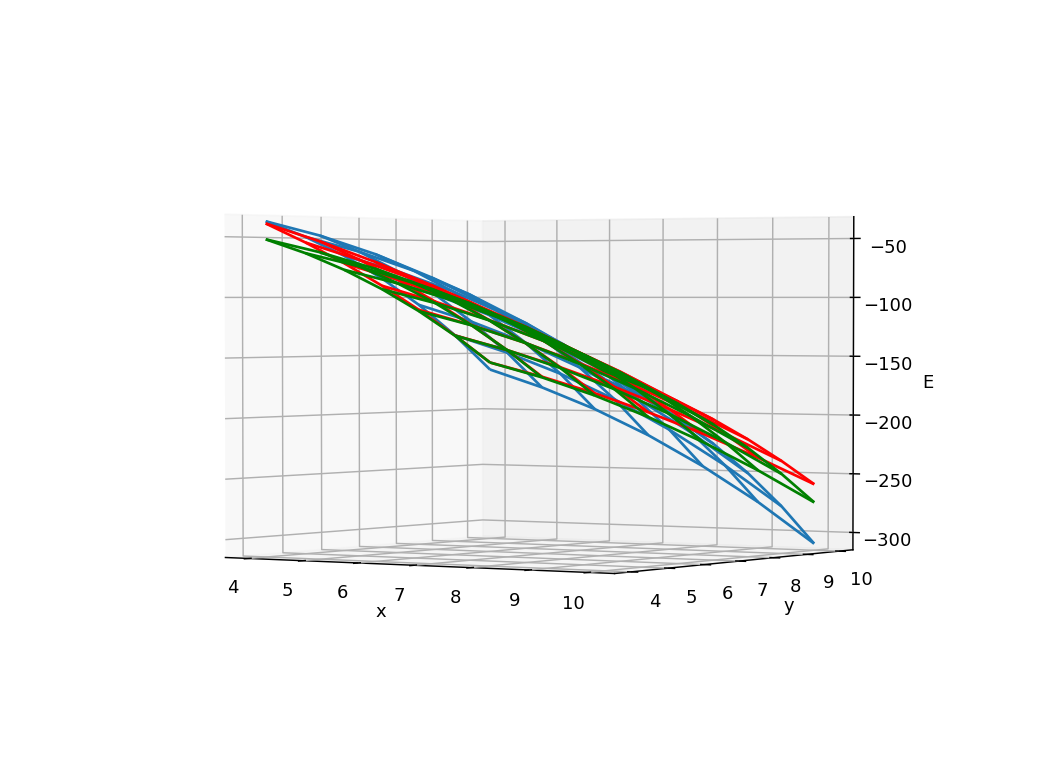

In [133]:
axes = [0,1]
data_prd_plt = {'x_mesh': Xs[0][:,:,3], 'y_mesh': Xs[1][:,:,3], 'E_mesh': Es_prd_mesh[:,:,3]}
#data_prd_CO_plt = {'x_mesh': Xs[0][:,:,3], 'y_mesh': Xs[1][:,:,3], 'E_mesh': Es_prd_CO_mesh[:,:,3]}
data_prd_CO_plt = {'x_mesh': Xs[0][:,:,3], 'y_mesh': Xs[1][:,:,3], 'E_mesh': Es_prd_mesh_dN[:,:,3]}
ax = nbplt.E_2D(data_prd_plt, color='r', axes=[0,2])
ax = nbplt.E_2D(data_prd_CO_plt, ax=ax, color='g', axes=[0,2])
nbplt.E_2D(test_data, ax=ax, axes=[0,2])
#nbplt.E_2D(test_data, ax=ax)

<IPython.core.display.Javascript object>


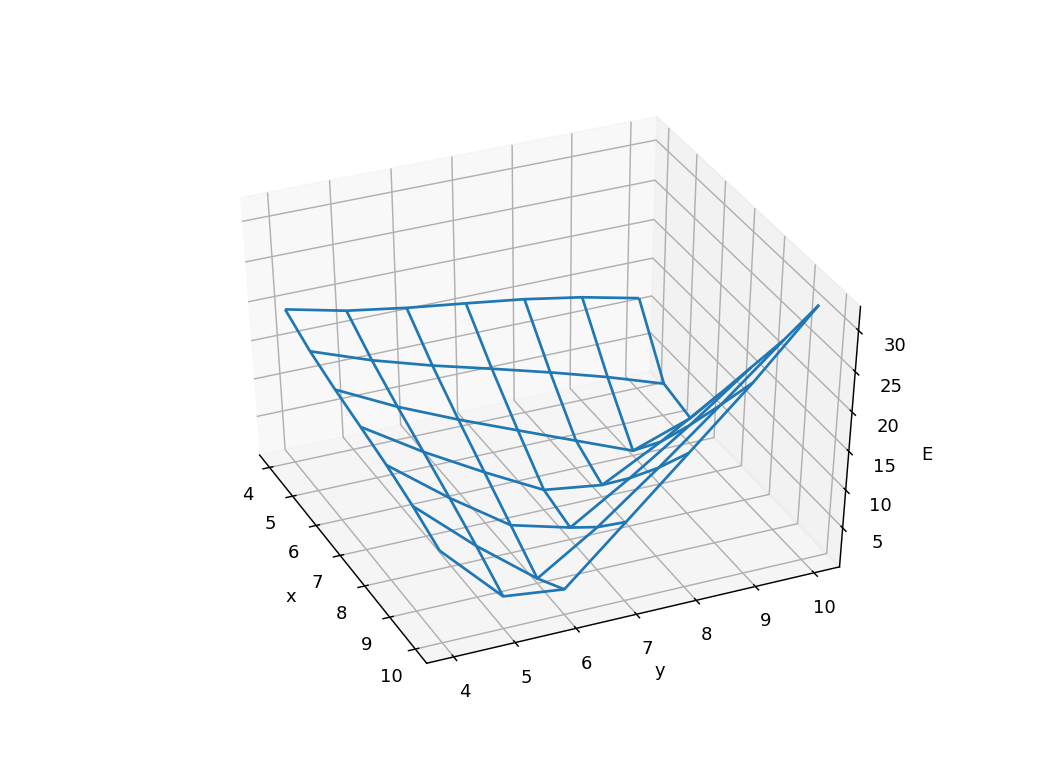

In [17]:
data_err_N2 = {
    'x_mesh': Xs[0][:,:,3], 
    'y_mesh': Xs[1][:,:,3], 
    'E_mesh': np.sqrt((Es_prd_mesh[:,:,3] - test_data['E_mesh']) ** 2)}
ax = nbplt.E_2D(data_err_N2)